# Visualization and explanation of the synthetic datasets

In this work, we use two synthetic datasets ```FourBars``` and ```ColorBar```, to test our algorithms with synthetic data. In this notebooks the generators are presented and the datasets are visualized.

In [1]:
import sys
sys.path.append("..")
import os
os.chdir("..")

In [28]:
# OTHER IMPORTS
import torch

# SETUP for the figures.
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-paper')

#plt.rc('font', family='Avenir', serif='Computer Modern')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)
plt.rc('axes', titlesize=8)
plt.rc('legend',fontsize=8) # using a size in points
plt.rcParams['axes.linewidth'] = 1.15
#plt.rcParams["figure.figsize"] = (6.,4.1631189606246317)

rc = {"axes.spines.left" : True,
      "axes.spines.right" : True,
      "axes.spines.bottom" : True,
      "axes.spines.top" : True,
      "xtick.bottom" : True,
      "xtick.labelbottom" : True,
      "ytick.labelleft" : True,
      "ytick.left" : True
     }

plt.rcParams.update({
    "text.usetex": True,
    #"font.sans-serif": ["Helvetica"]}
    "text.usetex": True,
    "pgf.texsystem": "pdflatex",
    "pgf.preamble": r"\usepackage{bm}",
    "font.family": "serif",
    # Use LaTeX default serif font.
    "font.serif": ["Times"],
    # Use specific cursive fonts.
    "font.cursive": ["Comic Neue", "Comic Sans MS"],

})
plt.rcParams.update(rc)

In [29]:
from data.four_bars import FourBars, ColorBar 

## Initialize the datasets and plot random samples and traversals

We implemented two datasets, FourBars and ColorBar. (see Figure 3a, 3b in the paper) FourBars has 4 factors of variation, whereas ColorBars only has 3.

In [141]:
## Use this flag to switch between datasets.
use_colorbar = True
n_intervals = 11
if use_colorbar:
    syn_dataset = ColorBar(n_intervals, nonlin_colors=False)
    num_factors = 3
else:
    syn_dataset = FourBars(n_intervals)
    num_factors = 4

In [142]:
# Use the sample_factors function, to draw n_gen valid factor combinations.
n_gen = 8
facts = syn_dataset.sample_factors(n_gen)

In [143]:
facts

array([[ 9,  8,  4],
       [ 0,  1,  8],
       [ 5, 10,  1],
       [ 1,  8,  6],
       [ 7,  0,  0],
       [ 3,  5,  8],
       [ 6,  3,  3],
       [ 1,  3,  3]])

... draws samples values of three / four factors in the range ```[0, n_intervals-1]```

In [144]:
# Then use sample_observations_from_factors to generate the actual images
batch = syn_dataset.sample_observations_from_factors(facts)

In [145]:
import matplotlib.pyplot as plt

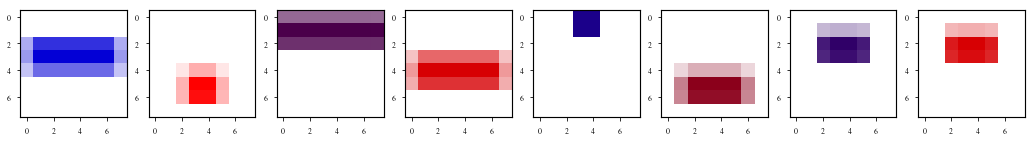

In [146]:
f, ax_list = plt.subplots(1,n_gen)
for idx, a in enumerate(ax_list):
    out = batch[idx]
    #print(out.shape)
    a.imshow(out)
plt.gcf().set_size_inches(18,9)

## Generate ground truth traversals

In [147]:
import torch
n_intervals = 7
facts = torch.ones(num_factors*n_intervals, num_factors)*5 # sample intervals.
for i in range(num_factors):
    facts[i*n_intervals:(i+1)*n_intervals,i] = torch.arange(n_intervals, dtype=torch.float)*(10./(n_intervals-1))

batch = syn_dataset.sample_observations_from_factors(facts)

In [148]:
import torchvision
import numpy as np
def plot_traversal(batch, n_row, savepath=None, plotsize=(8,6)):
    batch = batch.transpose(3,2).transpose(2,1)
    img = torchvision.utils.make_grid(batch, nrow=n_row, padding =1)
    img = img.transpose(0,1).transpose(1,2)
    #print(img.shape)
    plt.imshow(img)
    height, width = img.shape[0], img.shape[1]
    num_img_width = n_row
    limits = [-1, 1]
    #lines = [r"$h_1$", r"$h_2$", r"$h_3$", r"$h_4$", r"$h_5$", r"$h_6$"]
    #lines = [r"$e_1$", r"$e_2$", r"$e_3$", r"$e_4$", r"$e_5$", r"$e_6$"]
    lines = [r"$z_1$", r"$z_2$", r"$z_3$"]
    plt.yticks((np.arange(0,3)+0.5)*(height/3), lines)
    plt.xticks(np.array([0.5,num_img_width/2, num_img_width-0.5])*(width/num_img_width), [str(limits[0]), "0", str(limits[1])])
    #plt.xlabel("magnitude of change")
    #plt.text(0.71, 0.715, f"dci={dci}", fontsize=8, transform=plt.gcf().transFigure)
    #plt.annotate(, (width-130, 0), fontsize=8)
    plt.gcf().set_size_inches(*plotsize)
    plt.tight_layout()
    if savepath is not None:
        plt.savefig(savepath, backend="pgf", dpi=800)

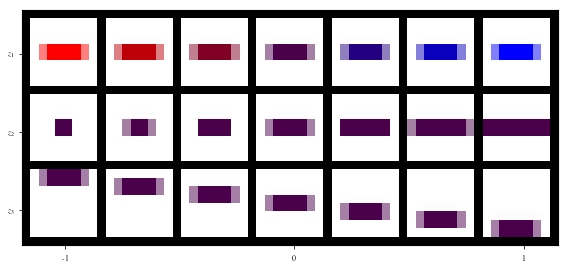

In [149]:
plot_traversal(torch.from_numpy(batch), n_row=n_intervals)

## Test gradient computation of generator.

In [150]:
# Define a sample to study
if use_colorbar:
    facts = torch.tensor([[2.6759, 0.787, 2.5879]]).reshape(1,3)
else:
    facts = torch.tensor([8.4, 9.9, 0.1, 8.4]).reshape(-1,4)
#facts.requires_grad_(True)
batch = syn_dataset.sample_observations_from_factors(facts, ret_torch=True)

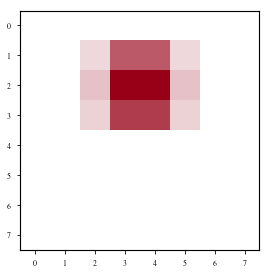

In [151]:
f, ax = plt.subplots()
ax.imshow(batch[0].detach().numpy())

We use the generator attribution function implemented in the ```attributions``` folder to compute the generators attributions. However, this function expects a generator object with a ```decode``` function. To this end, we construct a Wrapper class around the ground truth generator.

In [152]:
class GTGenWrapper():
    def __init__(self, gt_process):
        self.my_gt = gt_process
    def decode(self, latent):
        return self.my_gt.sample_observations_from_factors(facts, ret_torch=True)
    
from common.attributions import generator_jacobian

In [153]:
batch = syn_dataset.sample_observations_from_factors(facts, ret_torch=True)
jac = generator_jacobian(GTGenWrapper(syn_dataset), facts)

tensor(0.1630)
tensor(1.3911)
tensor(3.1750)


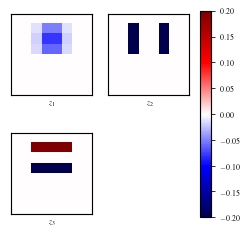

In [154]:
f, ax_list = plt.subplots(2, 2)


ax_list = list(ax_list[0]) + list(ax_list[1])

if num_factors ==3:
    ax_list[-1].axis("off")
    ax_list = ax_list[:-1]
mres=0
for idx, a in enumerate(ax_list):
    out = torch.sum(jac[0, idx,:,:,:], dim=-1)
    print(out.norm()) # Print the norm of the attribution 
    im = a.matshow(out, vmin=-0.2, vmax=0.2, cmap="seismic")
    a.set_xticks([])
    a.set_yticks([])
    a.set_xlabel(f"$z_{idx+1}$")
#plt.tight_layout()
cbar = plt.colorbar(im, ax=ax_list, shrink=0.95)
#cbar.ax.set_ylabel('gradients (channel sum)')
#plt.gcf().set_size_inches(2)
plt.gcf().set_size_inches(4, 4)
plt.show()

## Test for orthogonal / disjoint attributions

Let's check if the attributions of the dataset are orthogonal (IMA) or disjoint (DMA)

In [155]:
jac[0].shape

torch.Size([3, 8, 8, 3])

Deviation:  tensor(5.6578e-08)


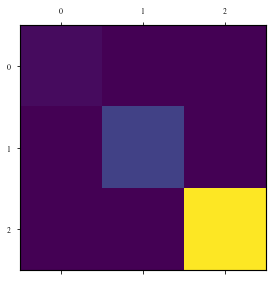

In [156]:
## Orthogonal gradients (IMA)
jacobian = jac[0].reshape(num_factors, -1)
prod = jacobian @ jacobian.t()
print("Deviation: ", torch.sum(torch.abs(prod-torch.diag(torch.diag(prod)))))
plt.matshow(prod)

Looks good for ```Colorbar``` and ```Fourbars```: Both have orthogonal jacobians.

Deviation:  tensor(1.0501)


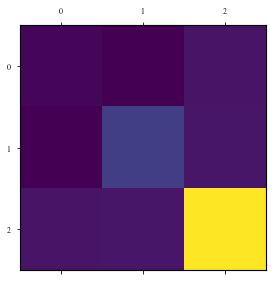

In [157]:
# Disjoint gradients (DMA) 
jacobian = jac[0].reshape(num_factors, -1)
prod = torch.abs(jacobian) @ torch.abs(jacobian).t()
print("Deviation: ", torch.sum(torch.abs(prod-torch.diag(torch.diag(prod)))))
plt.matshow(prod)

Not diagonal for ```Colorbar```, which does not have disjoint jacobians. ```FourBars``` features disjoint jacobians.

torch.Size([21, 3])
torch.Size([21, 8, 8, 3]) <class 'torch.Tensor'>


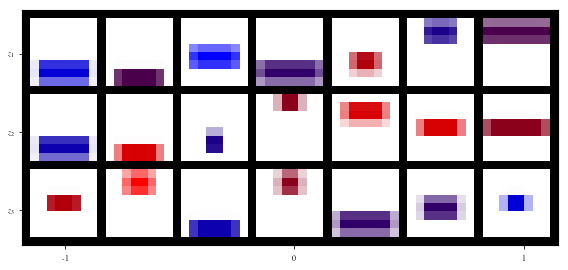

In [158]:
## Plot a random sample (used in the appendix)
n_intervals = 7
n_gen = n_intervals*num_factors
facts = torch.tensor(syn_dataset.sample_factors(n_gen), dtype=torch.float)
print(facts.shape)
batch = syn_dataset.sample_observations_from_factors(facts, ret_torch=True)
print(batch.shape, type(batch))
#batch = batch.transpose(3,2).transpose(2, 1)
plot_traversal(batch, n_row=n_intervals)